# Constructing Equivariant Models

Previously we showed examples of finding equivariant bases for different groups and representations, now we'll show how these bases can be assembled into equivariant neural networks such as EMLP. 

We will give examples at a high level showing how the specific EMLP model can be applied to different groups and input-output types, and later in a lower level showing how models like EMLP can be constructed with equivariant layers and making use of the equivariant bases.

## Using EMLP with different groups and representations (high level)

![ex 2.13](imgs/EMLP_fig.png)

A basic EMLP is a sequence of EMLP layers (containing G-equivariant linear layers, bilinear layers incorporated with a shortcut connection, and gated nonlinearities. While our numerical equivariance solver can work with any finite dimensional linear representation, for EMLP we restrict ourselves to _tensor_ representations.

By tensor representations, we mean all representations which can be formed by arbitrary combinations of $\oplus$,$\otimes$,$^*$ (`+`,`*`,`.T`) of a base representation $\rho$. This is useful because it simplifies the construction of our bilinear layer, which is a crucial ingredient for expressiveness and universality in EMLP.

Following the $T_{(p,q)}=V^{\otimes p}\otimes (V^*)^{\otimes p}$ notation in the paper, we provide the convenience function for constructing higher rank tensors.

In [1]:
from emlp.solver.representation import V
from emlp.solver.groups import SO13

def T(p,q=0):
    return (V**p*V.T**q)

print(T(2,3))
print(T(2,3)(SO13()))

V⊗V⊗V*⊗V*⊗V*
V²⊗V*³


Lets get started with a toy dataset: learning how an inertia matrix depends on the positions and masses of 5 point masses distributed in different ways. The data consists of mappings (positions, masses) --> (inertia matrix) pairs, and has an $G=O(3)$ symmetry (3D rotation and reflections). If we rotate all the positions, the resulting inertia matrix should be correspondingly rotated.

In [82]:
from emlp.models.datasets import Inertia
from emlp.solver.groups import SO,O,S,Z
trainset = Inertia(1000) # Initialize dataset with 1000 examples
testset = Inertia(2000)
G = SO(3)
print(f"Input type: {trainset.rep_in(G)}, output type: {trainset.rep_out(G)}")

Input type: 5V⁰+5V, output type: V²


For convenience, we store in the dataset the types for the input and the output. `5V⁰` are the $5$ mass values and `5V` are the position vectors of those masses, `V²` is the matrix type for the output, equivalent to $T_2$. To initialize the EMLP, we just need these input and output representations, the symmetry group, and the size of the network as parametrized by number of layers and number of channels (the dimension of the feature representation).

In [83]:
from emlp.models.mlp import EMLP,MLP
model = EMLP(dataset.rep_in,dataset.rep_out,group=G,num_layers=3,ch=384)
# uncomment the following line to instead try the MLP baseline
#model = MLP(dataset.rep_in,dataset.rep_out,group=G,num_layers=3,ch=384)

In [84]:
BS=500
lr=3e-3
NUM_EPOCHS=1000

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

opt = objax.optimizer.Adam(model.vars())

@objax.Function.with_vars(model.vars())
def loss(x, y,training=True):
    yhat = model(x, training=training)
    return ((yhat-y)**2).mean()


gv = objax.GradValues(loss, model.vars())

@objax.Function.with_vars(model.vars())
def train_op(x, y, lr):
    g, v = gv(x, y)
    opt(lr=lr, grads=g)
    return v

train_op = objax.Jit(train_op)
test_loss = objax.Jit(objax.ForceArgs(loss, training=False))

trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

In [85]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
    if not epoch%10:
        test_losses.append(np.mean([test_loss(jnp.array(x),jnp.array(y)) for (x,y) in testloader]))

  0%|          | 0/1000 [00:00<?, ?it/s]

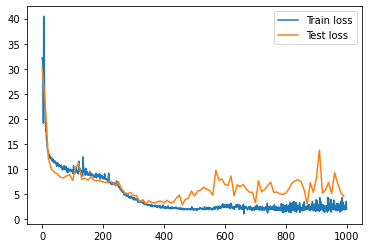

In [86]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()

In [5]:
from emlp.models.mlp import uniform_rep
r = uniform_rep(512,G)
print(r)

In [5]:
# class EMLP(Module,metaclass=Named):
#     def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):#@
#         super().__init__()
#         logging.info("Initing EMLP")
#         self.rep_in =rep_in(group)
#         self.rep_out = rep_out(group)
        
#         self.G=group
#         # Parse ch as a single int, a sequence of ints, a single Rep, a sequence of Reps
#         if isinstance(ch,int): middle_layers = num_layers*[uniform_rep(ch,group)]#[uniform_rep(ch,group) for _ in range(num_layers)]
#         elif isinstance(ch,Rep): middle_layers = num_layers*[ch(group)]
#         else: middle_layers = [(c(group) if isinstance(c,Rep) else uniform_rep(c,group)) for c in ch]
#         #assert all((not rep.G is None) for rep in middle_layers[0].reps)
#         reps = [self.rep_in]+middle_layers
#         #logging.info(f"Reps: {reps}")
#         self.network = Sequential(
#             *[EMLPBlock(rin,rout) for rin,rout in zip(reps,reps[1:])],
#             LieLinear(reps[-1],self.rep_out)
#         )
#         #self.network = LieLinear(self.rep_in,self.rep_out)
#     def __call__(self,x,training=True):
#         return self.network(x)

NameError: name 'Module' is not defined

## Equivariant Linear Layers (low level)